In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Get current working directory (where notebook is running)
current_dir = os.getcwd()
# Go up one level, then into utils
utils_path = os.path.abspath(os.path.join(current_dir, '..', 'utils'))
# Add to sys.path
sys.path.append(utils_path)

from trend_regime_utils import load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth
from bull_trend_regime_utils import load_bull_trend_data, create_advanced_bull_feat, merge_clean_final_clusters

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib

# For API Keys
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWar

In [3]:
# Get the project root (one level up from current working directory)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

In [4]:
df_bull_raw = load_bull_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

bull_features_df = create_advanced_bull_feat(df_bull_raw)

In [5]:
# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]

In [6]:
## If want to predict
# Load models
bull_scaler = joblib.load(os.path.join(MODEL_DIR, "bull_trend_scaler.pkl"))
bull_umap_model = joblib.load(os.path.join(MODEL_DIR, "bull_trend_umap_model.pkl"))
spectral_model = joblib.load(os.path.join(MODEL_DIR, "bull_trend_spectral_model.pkl"))

# scale data
bull_trend_scaled = bull_scaler.transform(only_bull_features_df)

# Apply UMAP transformation
bull_trend_umap = bull_umap_model.transform(bull_trend_scaled)

# Predict clusters, SpectralClustering doesn’t have a .predict() method for unseen data.
# Every time you call fit_predict(), it re-computes clusters from scratch, so for new data, you need to re-run it on all data (old + new)
bull_trend_spectral_labels = spectral_model.fit_predict(bull_trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(bull_trend_umap, bull_trend_spectral_labels))

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [7]:
# compute final clusters
df_final_clusters = merge_clean_final_clusters(bull_trend_spectral_labels, only_bull_features_df, df_with_clusters)

df_final_clusters.value_counts(normalize=True, dropna=False)

final_cluster
1                0.251719
0                0.240257
2                0.187987
3                0.175608
4                0.144429
Name: proportion, dtype: float64

In [8]:
tickers_to_trade = [
    "SPY",  # S&P 500 ETF
    "EFA",  # MSCI EAFE (Developed Markets ex-US) ETF
    "EEM",  # MSCI Emerging Markets ETF
    "TLT",  # 20+ Year Treasury Bond ETF
    "GLD",  # Gold ETF
    "USO",  # Crude Oil ETF
    "QQQ",  # Nasdaq 100 ETF
    "IWM"   # Russell 2000 ETF
]

df_trade_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=tickers_to_trade)

print("NAs: ", df_trade_raw.pivot(columns="symbol").isna().sum().sum())

NAs:  0


In [ ]:
def add_sma_crossover(df, short_window=20, long_window=50):
    """Buy when short SMA crosses above long SMA, sell when crosses below."""
    """Trend-following / Momentum"""
    df = df.copy()
    df['SMA_short'] = df['close'].rolling(short_window).mean()
    df['SMA_long'] = df['close'].rolling(long_window).mean()
    df['S1_signal'] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    return df.drop(columns=['SMA_short', 'SMA_long'])

def add_rsi(df, period=14):
    """Buy when RSI < 30 (oversold), sell when RSI > 70 (overbought)."""
    """Mean reversion"""
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    df['S2_signal'] = np.where(df['RSI'] < 30, 1, np.where(df['RSI'] > 70, -1, 0))
    return df.drop(columns=['RSI'])

def add_bollinger_bands_relaxed(df, window=20, num_std=2):
    """Buy when price closes below lower band, sell when above upper band."""
    """Volatility breakout & Reversion"""
    df = df.copy()
    sma = df['close'].rolling(window).mean()
    rolling_std = df['close'].rolling(window).std()
    upper_band = sma + num_std * rolling_std
    lower_band = sma - num_std * rolling_std
    band_width = upper_band - lower_band
    dist_upper = (upper_band - df['close']) / band_width  # normalized distance to upper band
    dist_lower = (df['close'] - lower_band) / band_width  # normalized distance to lower band

    # Signals: +1 if close near or below lower band (dist_lower < 0.2)
    #         -1 if close near or above upper band (dist_upper < 0.2)
    df['S3_signal'] = 0
    df.loc[dist_lower < 0.2, 'S3_signal'] = 1
    df.loc[dist_upper < 0.2, 'S3_signal'] = -1

    return df

def add_momentum(df, window=20):
    """Buy if return over last N days is positive, sell if negative."""
    """Momentum"""
    df = df.copy()
    df['momentum'] = df['close'] / df['close'].shift(window) - 1
    df['S4_signal'] = np.where(df['momentum'] > 0, 1, -1)
    return df.drop(columns=['momentum'])

def add_atr_breakout_relaxed(df, window=14, atr_mult=0.0, near_threshold=0.25):
    """	Buy when price breaks above previous N-day high + ATR buffer, sell on break below N-day low − ATR buffer."""
    """Volatility breakout"""
    df = df.copy()

    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window).mean()

    rolling_high = df['high'].rolling(window).max().shift(1)
    rolling_low = df['low'].rolling(window).min().shift(1)
    long_break = rolling_high + atr_mult * atr
    short_break = rolling_low - atr_mult * atr
    df['S5_signal'] = 0 

    # almost breakout
    df.loc[df['close'] > (long_break - near_threshold * atr), 'S5_signal'] = 1
    df.loc[df['close'] < (short_break + near_threshold * atr), 'S5_signal'] = -1

    return df

def add_macd(df, fast=12, slow=26, signal_window=9):
    """Buy when MACD line crosses above signal line, sell when crosses below."""
    """Trend-following"""
    df = df.copy()
    ema_fast = df['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    df['S6_signal'] = np.where(macd_line > signal_line, 1, -1)
    return df

# ---- Apply all strategies ----
def add_all_strategies(df):
    df = add_sma_crossover(df)
    df = add_rsi(df)
    df = add_bollinger_bands_relaxed(df)
    df = add_momentum(df)
    df = add_atr_breakout_relaxed(df)
    df = add_macd(df)
    return df

df_strats = add_all_strategies(df_trade_raw)

# How This Works
# Signals are numeric:
# 1 = long bias,
# -1 = short bias,
# 0 = neutral (for RSI & Bollinger).

# No lookahead bias in signal generation: All rolling and EMA operations use only past data.

# Drop helper columns so only S1_signal to S6_signal remain, ready for ML feature building.

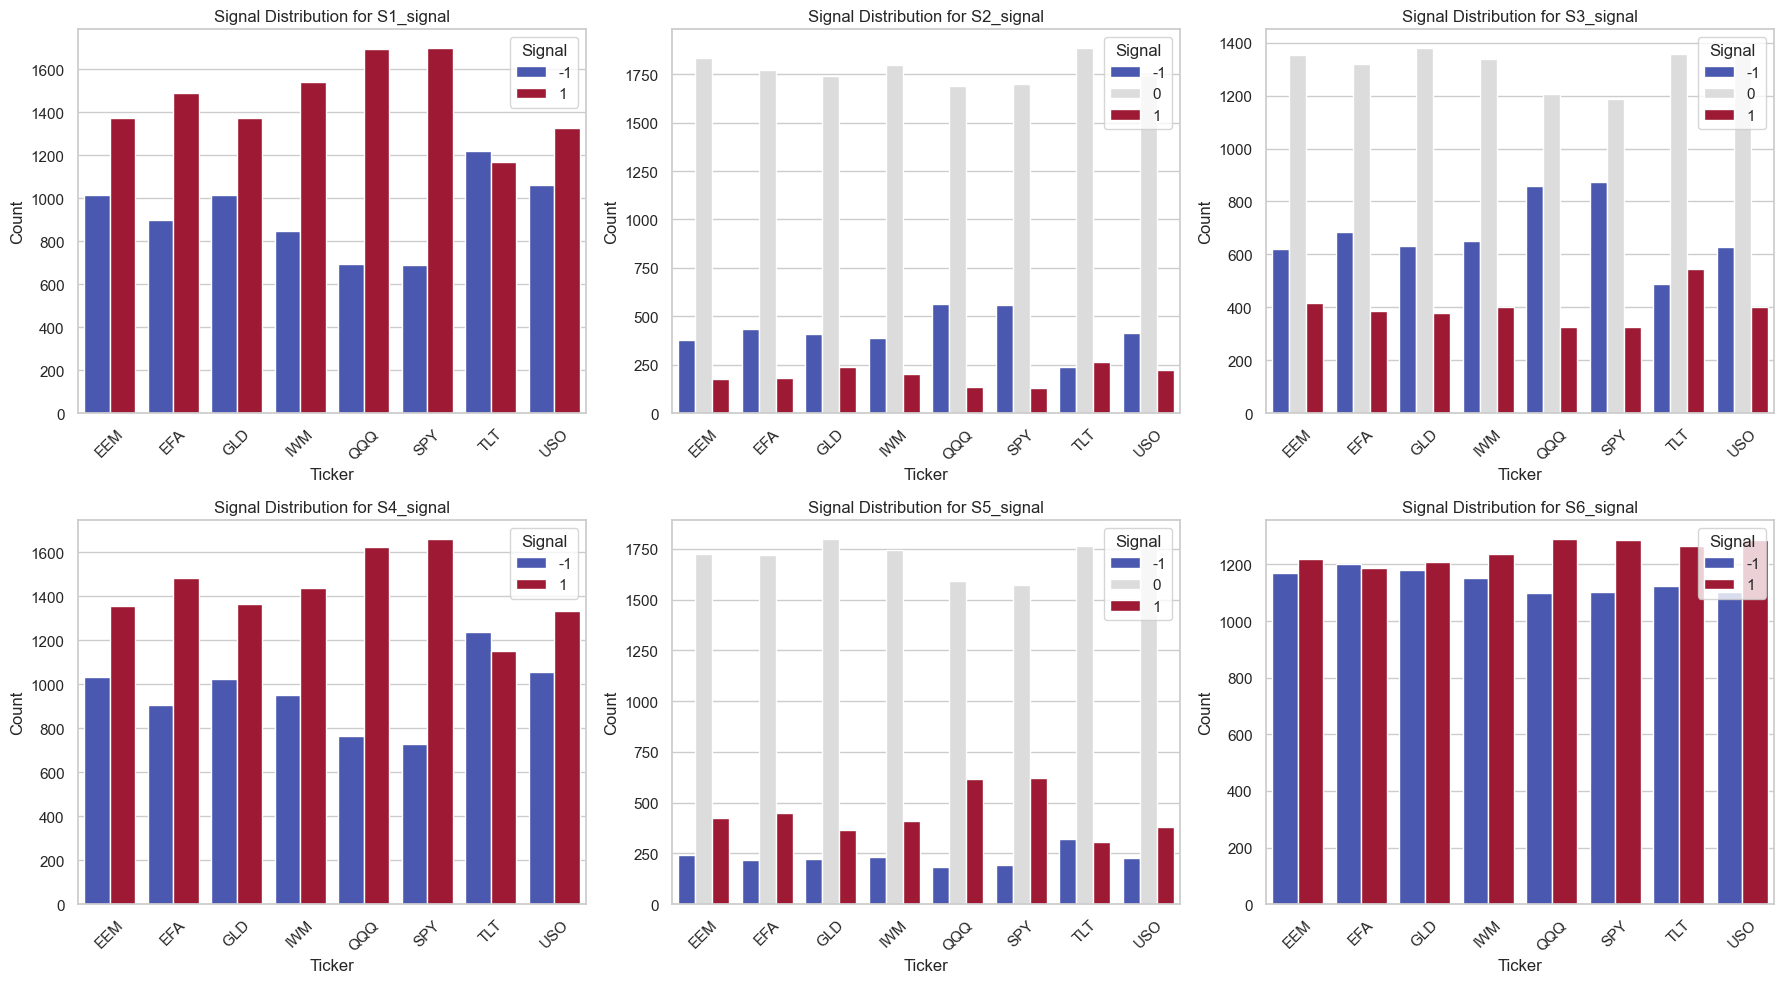

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_signal_distribution(df, signal_cols, symbol_col='symbol'):
    """
    Plots barplots showing distribution of signal values (1, 0, -1)
    per ticker and per strategy in a 3x2 subplot layout.
    """
    sns.set(style="whitegrid")
    
    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    axes = axes.flatten()  # Flatten to easily iterate
    
    for i, strat in enumerate(signal_cols):
        ax = axes[i]
        
        # Count frequency of each signal per ticker
        counts = (
            df.groupby(symbol_col)[strat]
            .value_counts()
            .unstack(fill_value=0)
            .reset_index()
            .melt(id_vars=symbol_col, var_name='Signal', value_name='Count')
        )
        
        # Plot on the corresponding subplot
        sns.barplot(data=counts, x=symbol_col, y='Count', hue='Signal', palette='coolwarm', ax=ax)
        
        ax.set_title(f"Signal Distribution for {strat}", fontsize=12)
        ax.set_xlabel("Ticker")
        ax.set_ylabel("Count")
        ax.legend(title="Signal")
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots if signal_cols < 6
    for j in range(len(signal_cols), 6):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

strategies = ['S1_signal', 'S2_signal', 'S3_signal', 'S4_signal', 'S5_signal', 'S6_signal']
plot_signal_distribution(df_strats, strategies)

In [11]:
HORIZON = 5

def compute_forward_returns(df, horizon=HORIZON):
    """
    For each symbol and timestamp, compute forward return over `horizon` days.
    Forward return = (close at t+horizon / close at t) - 1
    """
    df = df.copy()
    df['forward_return'] = df.groupby('symbol')['close'].shift(-horizon) / df['close'] - 1
    return df

def generate_strategy_returns(df, horizon=HORIZON):
    """
    For each strategy S1..S6, compute forward return assuming you go LONG when signal=1,
    SHORT when signal=-1, and 0 when neutral (signal=0).
    
    The strat_return per row per strategy is:
      forward_return * signal at current time
    
    Returns a DataFrame in long format:
      ['symbol', 'timestamp', 'strategy', 'signal', 'forward_return', 'strat_return']
    """
    df = df.copy()
    df = compute_forward_returns(df, horizon=horizon)
    
    strategy_cols = [f'S{i}_signal' for i in range(1,7)]
    records = []
    
    for strat in strategy_cols:
        temp = df[['symbol', 'close', strat, 'forward_return']].copy()
        temp = temp.rename(columns={strat: 'signal'})
        temp['strategy'] = strat
        
        # strat_return is forward return weighted by position signal
        # Long = profit if price rises, Short = profit if price falls
        temp['strat_return'] = temp['forward_return'] * temp['signal']
        
        ###### Optionally remove neutral signals to reduce noise
        # Neutral signals are safe to exclude if you want your model to focus on
        #  performance conditional on entering a trade. Keep them if you want 
        # the model to learn when to trade vs when not to
        temp = temp[temp['signal'] != 0]
        
        records.append(temp[['symbol', 'strategy', 'signal', 'forward_return', 'strat_return']])
    
    df_strat_returns = pd.concat(records).reset_index()
    return df_strat_returns.set_index('timestamp')


df_return_strats = generate_strategy_returns(df_strats, horizon=HORIZON)

In [12]:
        ###### Optionally remove neutral signals to reduce noise
        # Neutral signals are safe to exclude if you want your model to focus on
        #  performance conditional on entering a trade. Keep them if you want 
        # the model to learn when to trade vs when not to

In [13]:
# shift clusters since they are computed at the end of the day, so that info is not available, drop frist day since is nan
shifted_regimes = df_final_clusters[["final_cluster"]].shift(1).dropna().astype(int)

# join with clusters (first months have no cluster so have to drop them)
df_joined = df_return_strats.join(shifted_regimes, how='inner')
df_joined.rename(columns={"final_cluster": "prev_regime"}, inplace=True)

df_joined.drop(columns="forward_return", inplace=True)
# drop last days without available returns
df_joined.dropna(subset=['strat_return'], inplace=True)

df_joined

,symbol,strategy,signal,strat_return,prev_regime
timestamp,,,,,
2016-11-14 05:00:00+00:00,EEM,S1_signal,-1,-0.018525,3
2016-11-15 05:00:00+00:00,EEM,S1_signal,-1,-0.013268,3
2016-11-16 05:00:00+00:00,EEM,S1_signal,-1,-0.010915,3
2016-11-17 05:00:00+00:00,EEM,S1_signal,-1,-0.014773,3
2016-11-18 05:00:00+00:00,EEM,S1_signal,-1,-0.022238,3
...,...,...,...,...,...
2025-07-07 04:00:00+00:00,USO,S6_signal,-1,0.011245,4
2025-07-08 04:00:00+00:00,USO,S6_signal,-1,0.022089,1
2025-07-09 04:00:00+00:00,USO,S6_signal,-1,0.022618,1


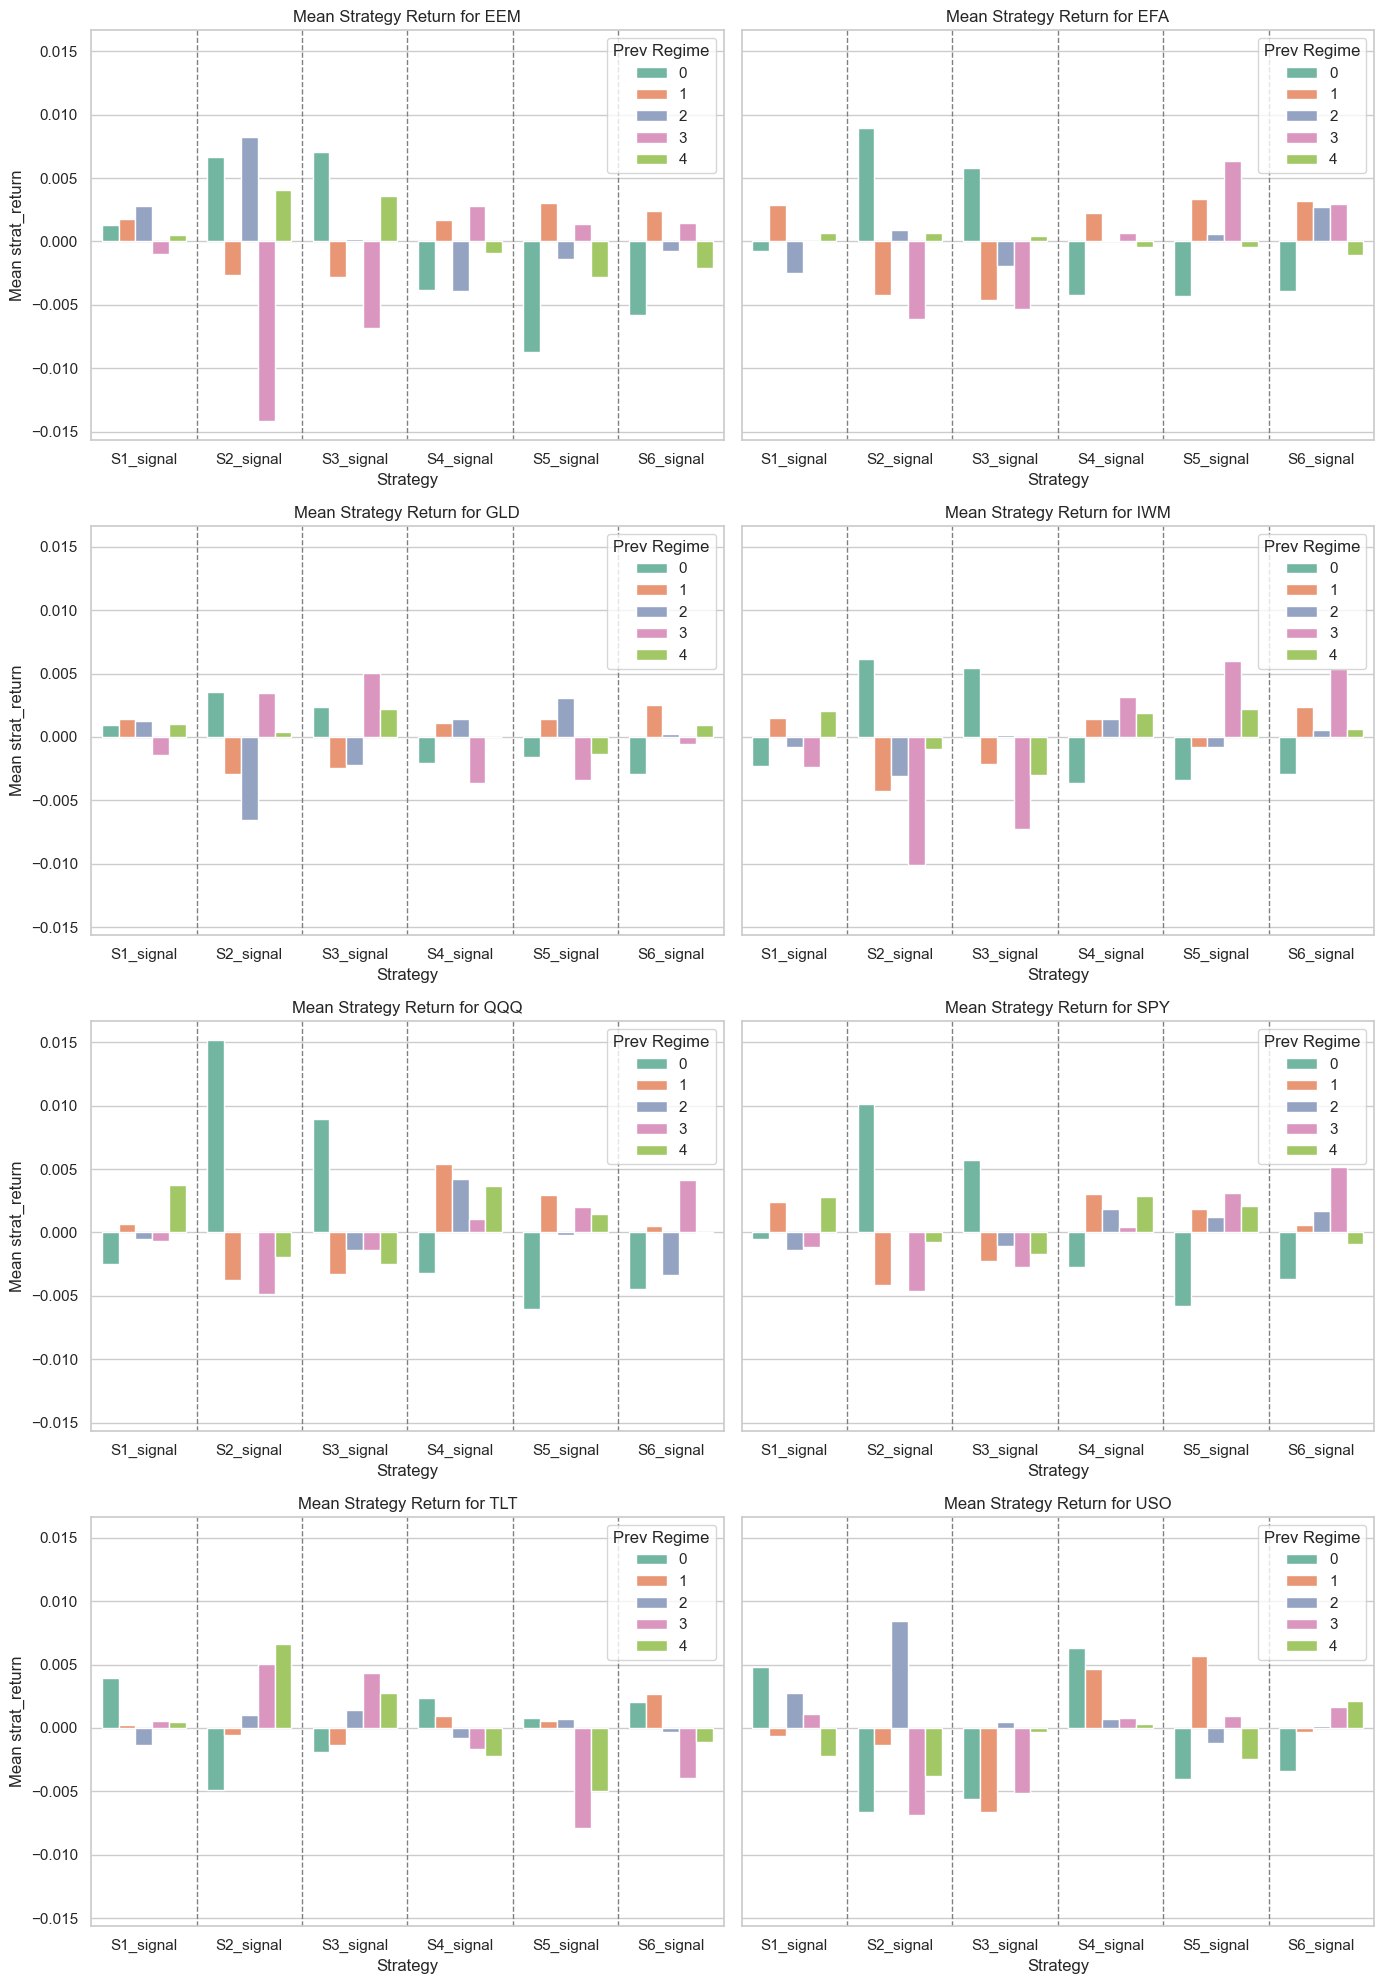

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_strat_return(df):
    """
    Plot mean strat_return grouped by symbol, strategy, and prev_regime.
    """
    # Compute mean strat_return
    grouped = df.groupby(['symbol', 'strategy', 'prev_regime'])['strat_return'].mean().reset_index()

    # Set seaborn style
    sns.set(style='whitegrid')

    symbols = grouped['symbol'].unique()
    n_symbols = len(symbols)

    # Create subplots, one per symbol (adjust cols and rows as needed)
    cols = 2
    rows = (n_symbols + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), sharey=True)
    axes = axes.flatten()

    for i, sym in enumerate(symbols):
        ax = axes[i]
        data = grouped[grouped['symbol'] == sym]

        # Draw barplot with strategy on x-axis, hue=prev_regime
        sns.barplot(
            data=data,
            x='strategy',
            y='strat_return',
            hue='prev_regime',
            ax=ax,
            palette='Set2'
        )

        ax.set_title(f'Mean Strategy Return for {sym}')
        ax.set_xlabel('Strategy')
        ax.set_ylabel('Mean strat_return')
        ax.legend(title='Prev Regime')

        # Add vertical delimiters between strategies
        # Strategies are categorical on x-axis, positions 0,1,2,...,n-1
        n_strategies = data['strategy'].nunique()
        for pos in range(0, n_strategies - 1):
            ax.axvline(pos + 0.5, color='gray', linestyle='--', linewidth=1)

    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Usage:
plot_mean_strat_return(df_joined)

In [15]:
def add_features(df):
    df = df.copy()

    # 1. Returns
    df['return_1d'] = df['close'].pct_change(1)
    df['return_3d'] = df['close'].pct_change(3)
    df['return_5d'] = df['close'].pct_change(5)

    # 2. Volatility (rolling std of returns)
    df['log_return_1d'] = np.log(df['close'] / df['close'].shift(1))
    df['vol_5d'] = df['log_return_1d'].rolling(window=5).std()
    df['vol_10d'] = df['log_return_1d'].rolling(window=10).std()
    df.drop(columns="log_return_1d",  inplace=True)

    # 3. Momentum (price relative to N-day ago)
    df['mom_5d'] = df['close'] / df['close'].shift(5) - 1
    df['mom_10d'] = df['close'] / df['close'].shift(10) - 1
    df['mom_20d'] = df['close'] / df['close'].shift(20) - 1

    # 4. Moving averages
    df['sma_5d'] = df['close'].rolling(window=5).mean()
    df['sma_10d'] = df['close'].rolling(window=10).mean()
    df['sma_20d'] = df['close'].rolling(window=20).mean()

    # 5. Price relative to moving averages
    df['price_div_sma5'] = df['close'] / df['sma_5d'] - 1
    df['price_div_sma10'] = df['close'] / df['sma_10d'] - 1
    df['price_div_sma20'] = df['close'] / df['sma_20d'] - 1

    # 6. Volume features
    df['vol_rolling_5d'] = df['volume'].rolling(window=5).mean()
    df['vol_rolling_10d'] = df['volume'].rolling(window=10).mean()
    df['vol_rolling_20d'] = df['volume'].rolling(window=20).mean()

    # 7. Volatility normalized by volume (volume volatility ratio)
    df['vol_vol_ratio_5d'] = df['vol_5d'] / (df['vol_rolling_5d'] + 1e-9)

    # 8. Price range (High-Low) relative to close
    df['range_pct'] = (df['high'] - df['low']) / df['close']

    # 9. ATR (Average True Range)
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['atr_14'] = tr.rolling(window=14).mean()

    # 10. Log volume change
    df['log_vol_change_1d'] = np.log(df['volume'] + 1) - np.log(df['volume'].shift(1) + 1)

    # Drop rows with NaNs due to rolling calculations
    df = df.dropna()

    return df.drop(columns=["open", "high", "low", "close", "volume", "trade_count", "vwap"])

# Example usage:
df_features = df_trade_raw.groupby('symbol', group_keys=False).apply(add_features)

C:\Users\sergi\AppData\Local\Temp\ipykernel_10580\3456674295.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df_trade_raw.groupby('symbol', group_keys=False).apply(add_features)


In [16]:
# join with previous dataset
# Set 'symbol' as part of the index
# Join on both index levels (timestamp and symbol)
final_df = df_features.set_index('symbol', append=True).join(df_joined.set_index('symbol', append=True), how='inner')

# back to column
final_df = final_df.reset_index(level='symbol')

final_df

,symbol,return_1d,return_3d,return_5d,vol_5d,vol_10d,mom_5d,mom_10d,mom_20d,sma_5d,...,vol_rolling_10d,vol_rolling_20d,vol_vol_ratio_5d,range_pct,atr_14,log_vol_change_1d,strategy,signal,strat_return,prev_regime
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,123476647.0,87007315.80,9.885085e-11,0.013538,0.594286,-0.535504,S1_signal,-1,-0.018525,3
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,123476647.0,87007315.80,9.885085e-11,0.013538,0.594286,-0.535504,S2_signal,1,0.018525,3
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,123476647.0,87007315.80,9.885085e-11,0.013538,0.594286,-0.535504,S3_signal,1,0.018525,3
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,123476647.0,87007315.80,9.885085e-11,0.013538,0.594286,-0.535504,S4_signal,-1,-0.018525,3
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,123476647.0,87007315.80,9.885085e-11,0.013538,0.594286,-0.535504,S6_signal,-1,-0.018525,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-10 04:00:00+00:00,USO,-0.020018,-0.014252,-0.002646,0.013823,0.012214,-0.002646,0.028373,0.052933,76.190,...,6334315.8,15747107.25,2.722877e-09,0.012667,2.103943,0.557689,S4_signal,1,0.010214,1
2025-07-10 04:00:00+00:00,USO,-0.020018,-0.014252,-0.002646,0.013823,0.012214,-0.002646,0.028373,0.052933,76.190,...,6334315.8,15747107.25,2.722877e-09,0.012667,2.103943,0.557689,S6_signal,-1,-0.010214,1
2025-07-11 04:00:00+00:00,USO,0.025202,0.004288,0.027929,0.017359,0.014084,0.027929,0.050279,0.033013,76.610,...,5831546.3,15527069.45,3.406933e-09,0.016432,2.135371,-0.401862,S1_signal,1,-0.017596,1


In [17]:
final_df.columns

Index(['symbol', 'return_1d', 'return_3d', 'return_5d', 'vol_5d', 'vol_10d',
       'mom_5d', 'mom_10d', 'mom_20d', 'sma_5d', 'sma_10d', 'sma_20d',
       'price_div_sma5', 'price_div_sma10', 'price_div_sma20',
       'vol_rolling_5d', 'vol_rolling_10d', 'vol_rolling_20d',
       'vol_vol_ratio_5d', 'range_pct', 'atr_14', 'log_vol_change_1d',
       'strategy', 'signal', 'strat_return', 'prev_regime'],
      dtype='object')

In [18]:
def walk_forward_splits(df, n_splits=5, min_train_size=0.5):
    """
    Time-aware walk-forward splits.
    - df: DataFrame with timestamp as index, symbol as a column.
    - n_splits: number of folds.
    - min_train_size: fraction of timestamps in the first training set.
    """
    df_reset = df.reset_index()  # bring timestamp into a column
    df_sorted = df_reset.sort_values('timestamp')
    
    timestamps = df_sorted['timestamp'].unique()
    n_timestamps = len(timestamps)
    
    initial_train_end = int(n_timestamps * min_train_size)
    step_size = (n_timestamps - initial_train_end) // n_splits
    
    for i in range(n_splits):
        train_end = initial_train_end + i * step_size
        val_end = train_end + step_size
        
        train_mask = df_sorted['timestamp'] <= timestamps[train_end - 1]
        val_mask = (df_sorted['timestamp'] > timestamps[train_end - 1]) & \
                   (df_sorted['timestamp'] <= timestamps[min(val_end - 1, n_timestamps - 1)])
        
        train_idx = df_sorted[train_mask].index
        val_idx = df_sorted[val_mask].index
        
        yield train_idx, val_idx

In [28]:
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error

# Train LightGBM with walk-forward CV (categorical support)
def train_lightgbm_walk_forward(df, features, target, categorical_features, n_splits=5):
    results = []
    
    for fold, (train_idx, val_idx) in enumerate(walk_forward_splits(df, n_splits=n_splits)):
        train_data = df.iloc[train_idx]
        val_data = df.iloc[val_idx]
        
        lgb_train = lgb.Dataset(
            train_data[features], 
            label=train_data[target],
            categorical_feature=categorical_features
        )
        lgb_val = lgb.Dataset(
            val_data[features], 
            label=val_data[target],
            categorical_feature=categorical_features
        )
        
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'seed': 42
        }
        
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_val],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=50)],
        )
        
        preds = model.predict(val_data[features])
        rmse = root_mean_squared_error(val_data[target], preds)
        results.append({'fold': fold+1, 'rmse': rmse})
        print(f"Fold {fold+1} RMSE: {rmse:.6f}")
    
    return pd.DataFrame(results)

In [29]:
# ternatively, label encode if your model can handle categories natively (e.g., LightGBM, CatBoost).
#  XGBoost can handle label-encoded categorical features, but only if you use its newer categorical feature support (introduced around v1.5+).
# final_df['strategy'] = final_df['strategy'].astype('category')
# final_df['regime'] = final_df['regime'].astype('category')

# only for Lightgbm or catboost (maybe xgboost also)
final_df['symbol'] = final_df['symbol'].astype('category')
final_df['strategy'] = final_df['strategy'].astype('category')
final_df['prev_regime'] = final_df['prev_regime'].astype('category')

In [30]:
# Categorical columns
categ_feats = ['symbol', 'strategy', 'prev_regime']

# Train LightGBM with walk-forward CV
cv_results = train_lightgbm_walk_forward(final_df,
                                         final_df.drop(columns=["strat_return"]).columns,
                                         categorical_features = categ_feats,
                                         target='strat_return',
                                         n_splits=5)

print(cv_results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5380
[LightGBM] [Info] Number of data points in the train set: 35027, number of used features: 25
[LightGBM] [Info] Start training from score 0.000643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.0327021	valid_1's rmse: 0.0241282
Fold 1 RMSE: 0.024128
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5380
[LightGBM] [Info] Number of data points in the train set: 41802, number of used features: 25
[LightGBM] [Info] Start training from score 0.000446
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.0314101	valid_1's rmse

In [31]:
# Use one-hot encoding or target encoding for categorical features (strategy, regime) 
# depending on your model or Embeddings (for deep learning).


# Scale numeric features if needed (standard scaler or robust scaler). only for non-trees

# Experiment with adding more features like volume weighted average price (VWAP), ATR, or more complex technical indicators.